In [1]:
### 常规分析包
import os
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### 绘图包
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # 输出PDF文字可编辑
### 其他
import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # 报错提示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

# 1. Summary of samples

In [2]:
meta = pd.read_excel('../Data/16s样本meta信息.xls', index_col=0)
meta.head(2)

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [ ]:
wgs_meta = pd.read_excel('../Data/宏基因66个样本分组表.xls', index_col=0)
wgs_meta.head(2)
meta['WMS'] = 0
for i in wgs_meta.index:
    if i == '1_2018_8_20（1_26）':
        ID = 'C1_26'
    else:
        ID = 'C'+i
    meta.loc[ID, 'WMS'] = 1

In [ ]:
infant = pd.read_csv('../Data/infant.csv', index_col=0)
infant.head(2)

In [ ]:
for i in meta.index:
    inf = meta.loc[i, 'SampleID_1'][0]
    #i, inf, [int(j[1:]) if str(j)[0]=='D' else j for j in infant.loc[inf, :].values]
    if i[0]=='C':
        meta.loc[i, infant.columns] = [int(j[1:]) if str(j)[0]=='D' else j for j in infant.loc[inf, :].values]
    else:
        meta.loc[i, infant.columns] = [np.nan for j in infant.loc[inf, :].values]

In [3]:
meta['Solid food'] = 0
meta['Breastfeeding'] = 1
for i in meta.index:
    if meta.loc[i, 'Sample_type']=='C':
        day = meta.loc[i, 'Day']
        solid_day = meta.loc[i, 'Day of introducing solid food']
        bf_day = meta.loc[i, 'Day of breastfeeding cessation']
        meta.loc[i, 'Solid food'] = 1 if day>=solid_day else 0
        meta.loc[i, 'Breastfeeding'] = 0 if day>=bf_day else 1

NameError: name 'meta' is not defined

In [4]:
meta['Feeding mode(BFD:0,MFD:1)'] = [0 if 'BFD' in str(i) else (1 if 'MFD' in str(i) else np.nan) for i in meta['GROUP按喂养方式分组']]
meta['Sibling(Y:1,N:0)'] = [0 if 'N' in str(i) else (1 if 'Y' in str(i) else np.nan) for i in meta['GROUP是否有兄弟姐妹：Y：有，N：无']]
meta['PAE(Y:1,N:0)'] = [0 if 'N_PAE' in str(i) else (1 if 'PAE' in str(i) else np.nan) for i in meta['GROUP母亲是否围产期抗生素暴露：PAE：是，N_PAE：否']]
meta['Allergy(Y:1,N:0)'] = [0 if 'N' in str(i) else (1 if 'Y' in str(i) else np.nan) for i in meta['GROUP有无过敏性疾病：Y：有，N：无']]

NameError: name 'meta' is not defined

In [8]:
meta.to_csv('../Data_preprocess/1.1.MetaData_raw.tsv', sep='\t', encoding='GBK')

# 2. Visulation of metadata

In [3]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
meta.head(2)

,SampleID,SampleID_1,Child_ID,Sample_type,Day,Time,MotherID,WMS,Gender,Mode of delivery,...,Day of the last sample,Number of samples,Day of introducing solid food,Day of breastfeeding cessation,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)","Sibling(Y:1,N:0)","PAE(Y:1,N:0)","Allergy(Y:1,N:0)"
ID,,,,,,,,,,,,,,,,,,,,,
C11_10,11_10,D_10,11,C,25.0,T10,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0
C11_11,11_11,D_11,11,C,29.0,T11,M11_M,0,Female,C-section,...,352.0,25.0,176.0,356.0,0.0,1.0,0.0,0.0,0.0,1.0


(22, 15)

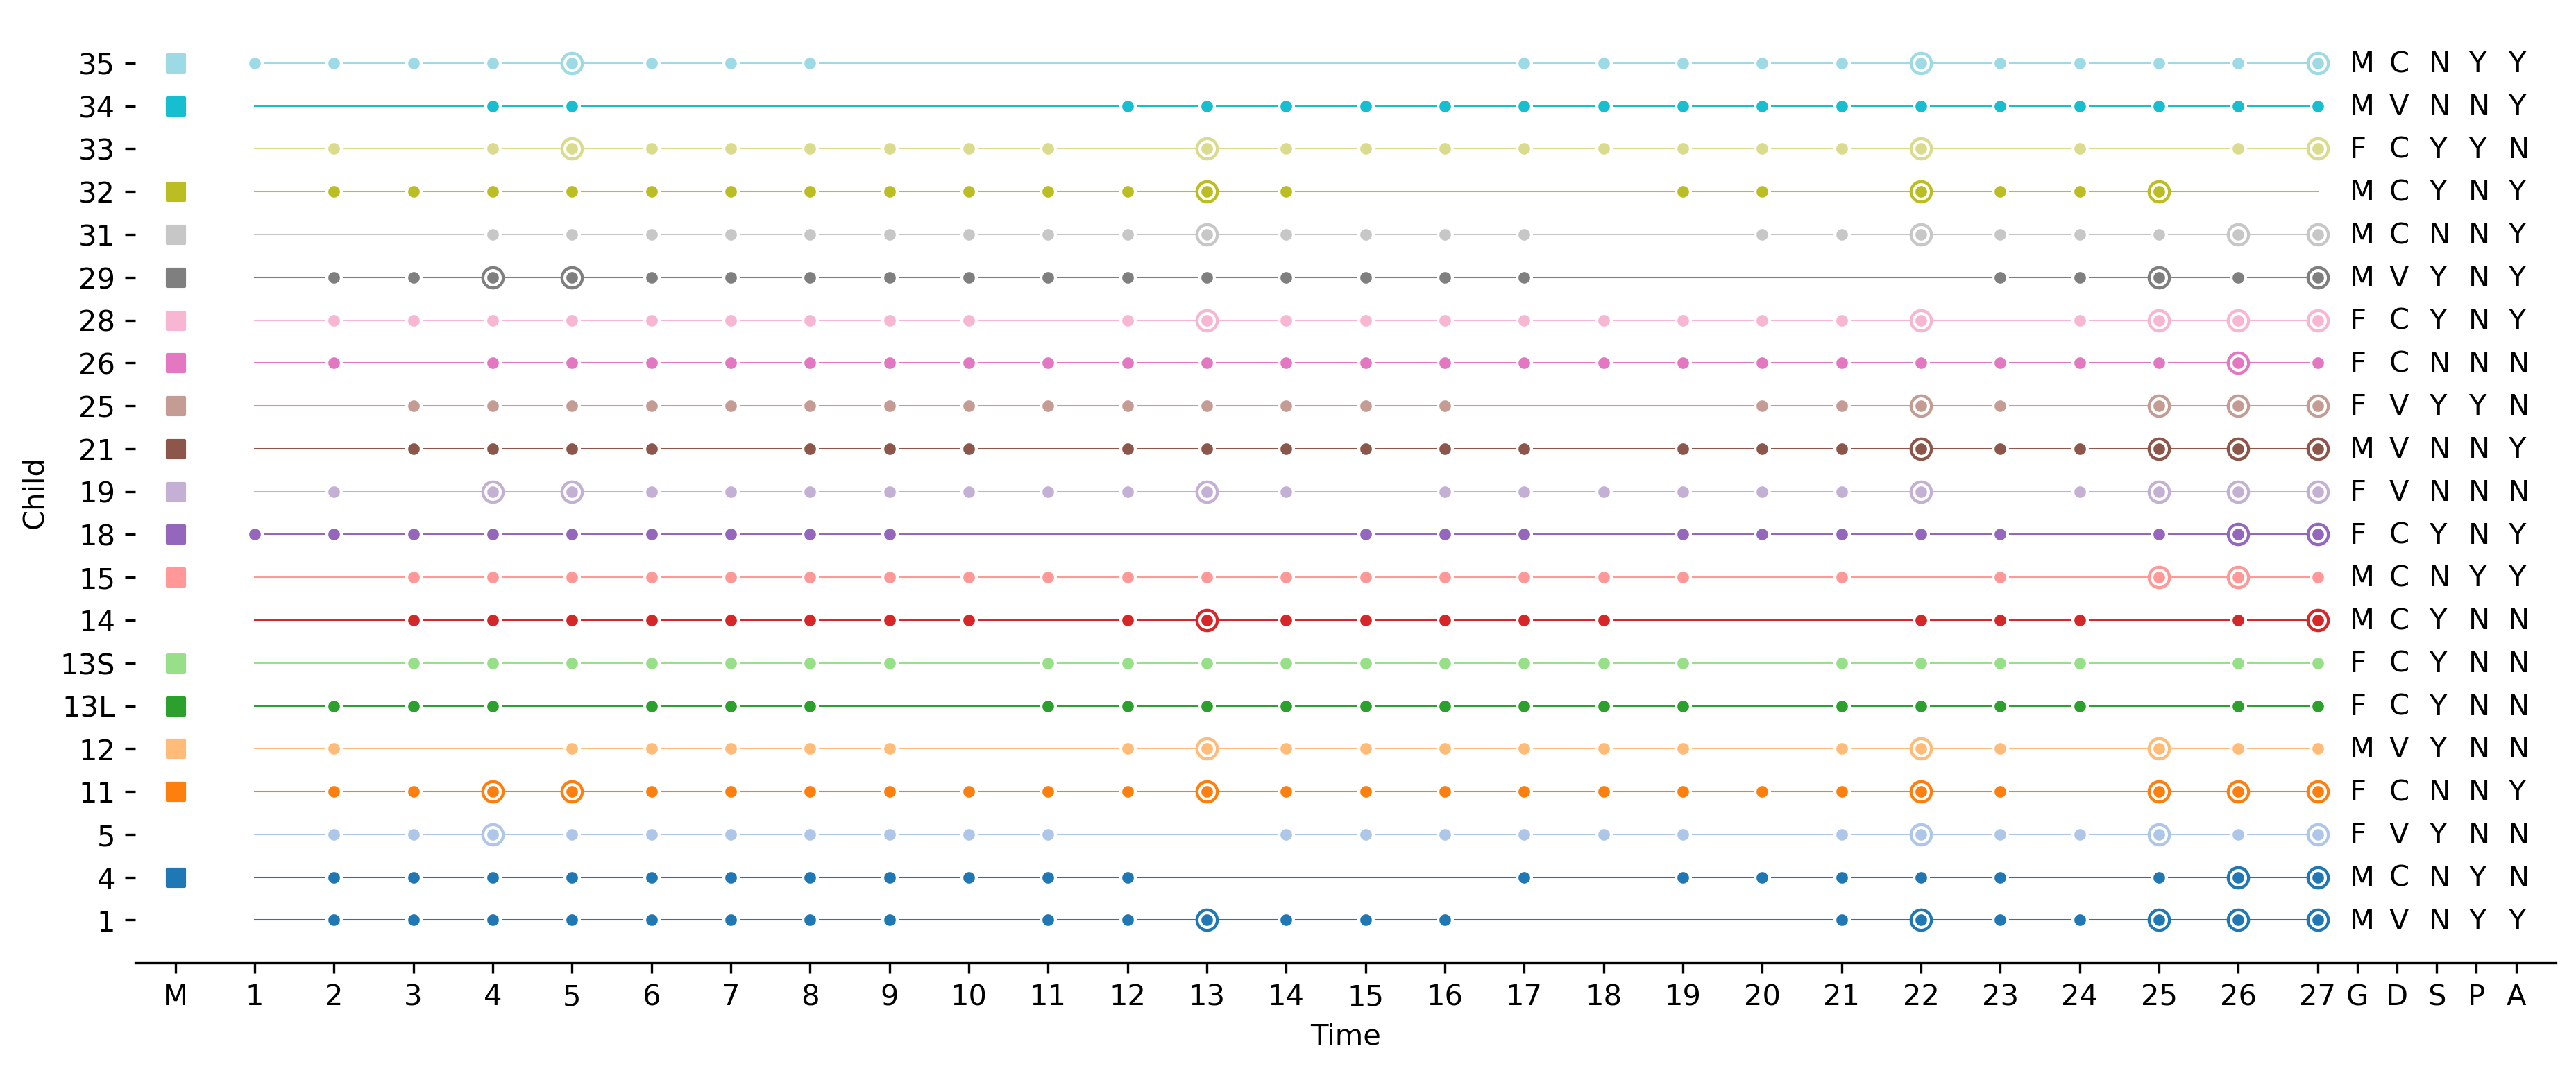

In [10]:
meta = pd.read_csv('../Data_preprocess/1.1.MetaData.tsv', sep='\t', index_col=0)
len(set(meta['Child_ID'])), sum(meta['Sample_type']=='M')
Childs = [1, 4, 5, 11, 12, '13L', '13S', 14, 15, 18, 19, 21, 25, 26, 28, 29, 31, 32, 33, 34, 35]

colors = plt.cm.tab20(np.arange(len(Childs))/len(Childs))
fig = plt.figure(figsize=(15, 6), dpi=300)
ax = plt.subplot(1,1,1)
index = 0
for C in Childs:
    MID = meta.loc[meta['Child_ID']==str(C), 'MotherID'].values[0]
    CSamples = meta.loc[meta['Child_ID']==str(C), :].index
    temp = meta.loc[CSamples, ['Time', 'WMS', 'Gender', 'Mode of delivery', 
                               'Sibling(Y:1,N:0)', 'PAE(Y:1,N:0)', 'Allergy(Y:1,N:0)']]
    temp['t'] = [int(i[1:]) for i in temp['Time']]
    temp = temp.sort_values('t')
    _ = plt.plot([1, 27], [index, index], zorder=-1, lw=0.5, color=colors[index])
    if str(MID).upper()!='NAN':
        _ = plt.scatter([0], [index], marker='s', color=colors[index])
    
    # WMS
    _ = plt.scatter(temp.loc[temp['WMS']==1, 't'], [index for i in temp.loc[temp['WMS']==1, 't']], 
                    marker='o', color=colors[index], s=50)
    # 16S
    _ = plt.scatter(temp['t'], [index for i in temp['t']], marker='o', color=colors[index], s=25,
                    linewidths=1., edgecolors='white')
    
    _ = plt.annotate('M' if temp['Gender'].values[0]=='Male' else 'F', (27.5-0.1, index-0.2))
    _ = plt.annotate('C' if temp['Mode of delivery'].values[0]=='C-section' else 'V', (28-0.1, index-0.2))
    _ = plt.annotate('Y' if temp['Sibling(Y:1,N:0)'].values[0]==1 else 'N', (28.5-0.1, index-0.2))
    _ = plt.annotate('Y' if temp['PAE(Y:1,N:0)'].values[0]==1 else 'N', (29-0.1, index-0.2))
    _ = plt.annotate('Y' if temp['Allergy(Y:1,N:0)'].values[0]==1 else 'N', (29.5-0.1, index-0.2))
    
    index += 1
xtick_labels = ['M']; xtick_labels.extend(range(1, 28)); xtick_labels.extend(['G', 'D', 'S', 'P', 'A'])
xticks = list(range(28)); xticks.extend([27.5, 28, 28.5, 29, 29.5])
_ = plt.xticks(xticks, xtick_labels)
_ = plt.yticks(range(len(Childs)), Childs)
_ = plt.xlim([-0.5, 30.])
_ = plt.xlabel('Time')
_ = plt.ylabel('Child')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig('../Results_0609/1.2. 16S样本分布情况.pdf', dpi=300)

,Solid food,Breastfeeding,"Feeding mode(BFD:0,MFD:1)",Day,Time
ID,,,,,
C11_10,0.0,1.0,0.0,25.0,T10
C11_11,0.0,1.0,0.0,29.0,T11


'Solid food'

'Breastfeeding'

'Feeding mode(BFD:0,MFD:1)'

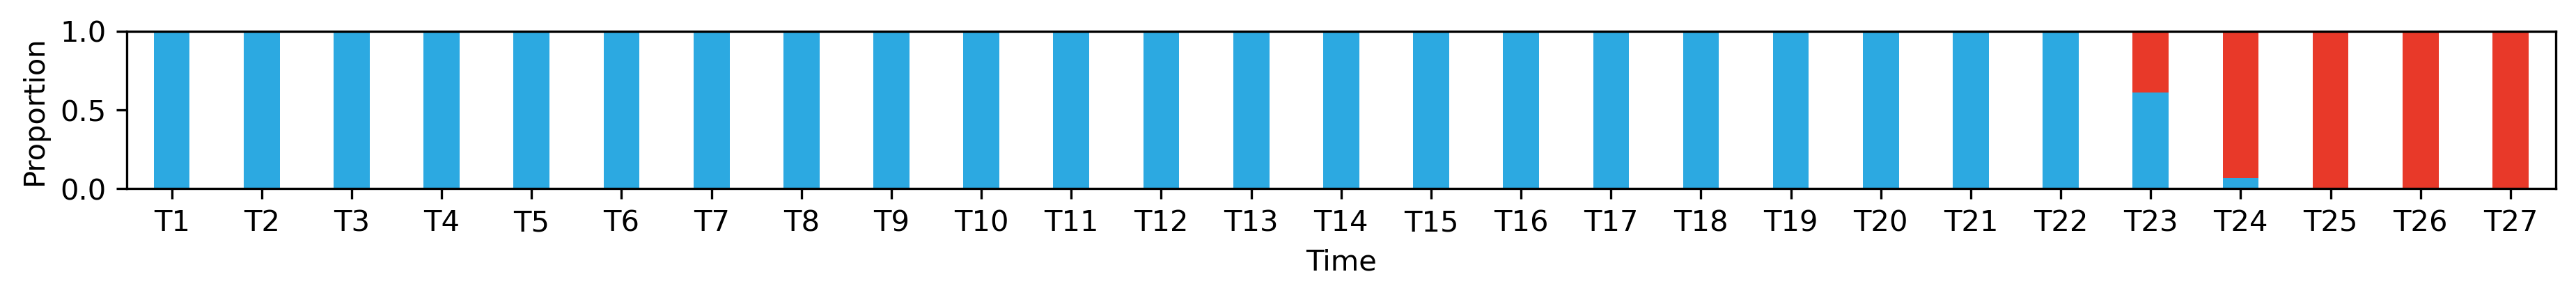

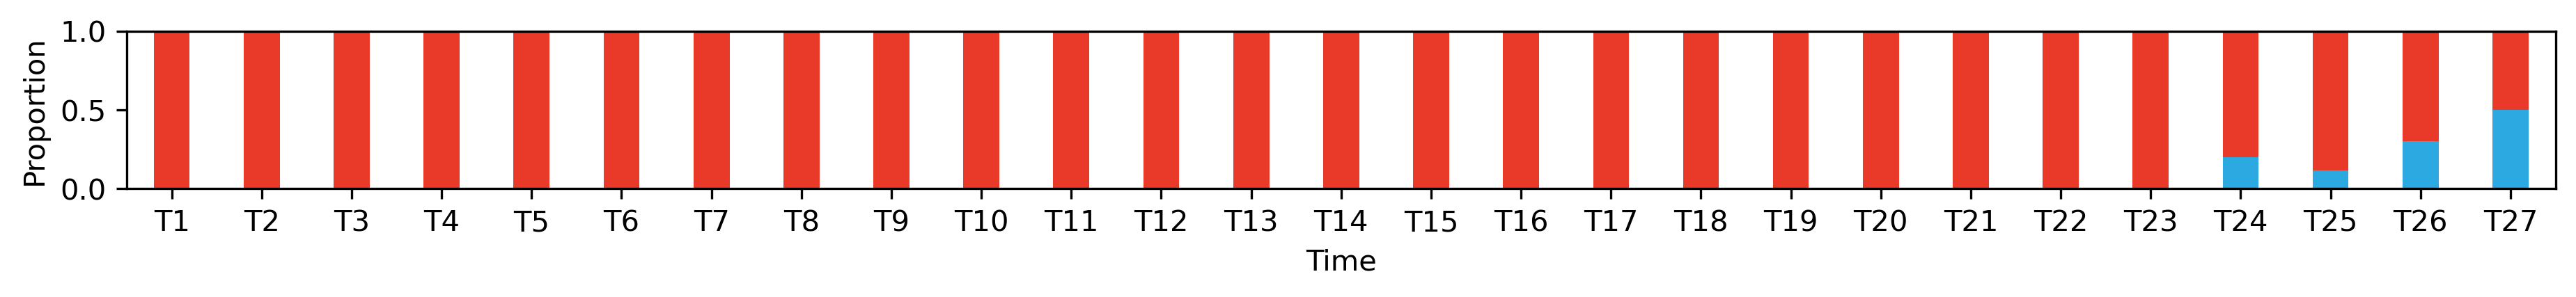

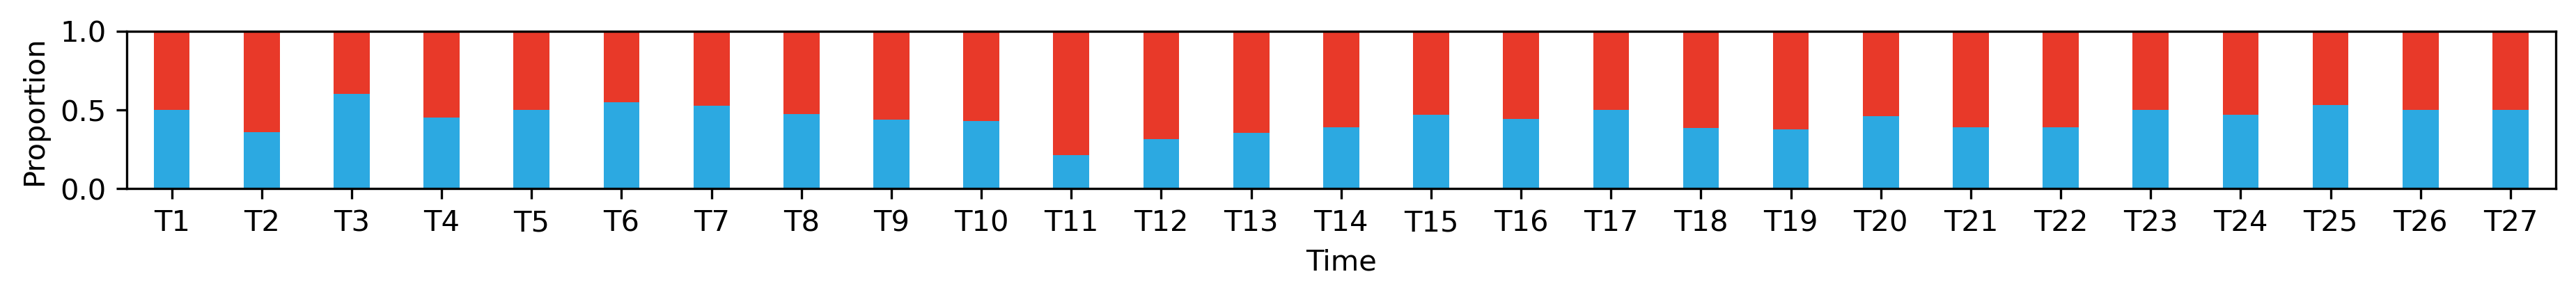

In [29]:
food = meta[['Solid food', 'Breastfeeding', 'Feeding mode(BFD:0,MFD:1)', 'Day', 'Time']]
food.head(2)
Childs = [1, 4, 5, 11, 12, '13L', '13S', 14, 15, 18, 19, 21, 25, 26, 28, 29, 31, 32, 33, 34, 35]

Times = ['T'+str(i) for i in range(1,28)]
res = food.groupby('Time').mean()

for f in ['Solid food', 'Breastfeeding', 'Feeding mode(BFD:0,MFD:1)']:
    temp = []
    for t in Times:
        temp.append(res.loc[t, f])
    f
    fig = plt.figure(figsize=(15, 1), dpi=300)
    ax = plt.subplot(1,1,1)
    _ = plt.bar(x=range(len(temp)), height=1-np.array(temp), bottom = 0, width=0.4, color='#2ca9e1')
    _ = plt.bar(x=range(len(temp)), height=temp, bottom = 1-np.array(temp), width=0.4, color='#e83929')
    _ = plt.xticks(range(len(temp)), Times)
    _ = plt.xlim([-0.5, 26.5])
    _ = plt.ylim([0, 1])
    _ = plt.xlabel('Time')
    _ = plt.ylabel('Proportion')
    fig.savefig('../Results_0609/1.2. 16S样本分布情况_food_'+f+'.pdf', dpi=300)

# 3. Read count

In [11]:
data = pd.read_csv('../Data/16S/MZJ_dada2_table_ASV.tsv', sep='\t', index_col=0, skiprows=1)
data.shape
data.head(2)

(10066, 466)

,C11_10,C1_11,C1_12,C1_13,C1_14,C1_15,C1_16,C1_2,C1_21,C1_22,...,M21_M,M25_M,M26_M,M28_M,M29_M,M31_M,M32_M,M34_M,M35_M,M4_M
#OTU ID,,,,,,,,,,,,,,,,,,,,,
3303dcf065483fbf1a02ff00a59b7848,0,0,39,55,43,0,206,923,883,147,...,0,0,0,0,0,0,78,0,0,0
44c9f59231dd703269388032da1d5a98,0,0,59,42,0,25,185,969,773,111,...,0,0,0,0,0,0,0,0,0,0


In [13]:
read_stats = meta.loc[meta['Sample_type']=='C', ['Child_ID', 'Time']]
read_stats['t'] = [int(i[1:]) for i in read_stats['Time']]
read_count = []
for i in read_stats.index:
    read_count.append(data.loc[:, i].sum())
read_stats['read_count'] = read_count
read_stats.head(2)

,Child_ID,Time,t,read_count
ID,,,,
C11_10,11,T10,10,18621
C11_11,11,T11,11,15250


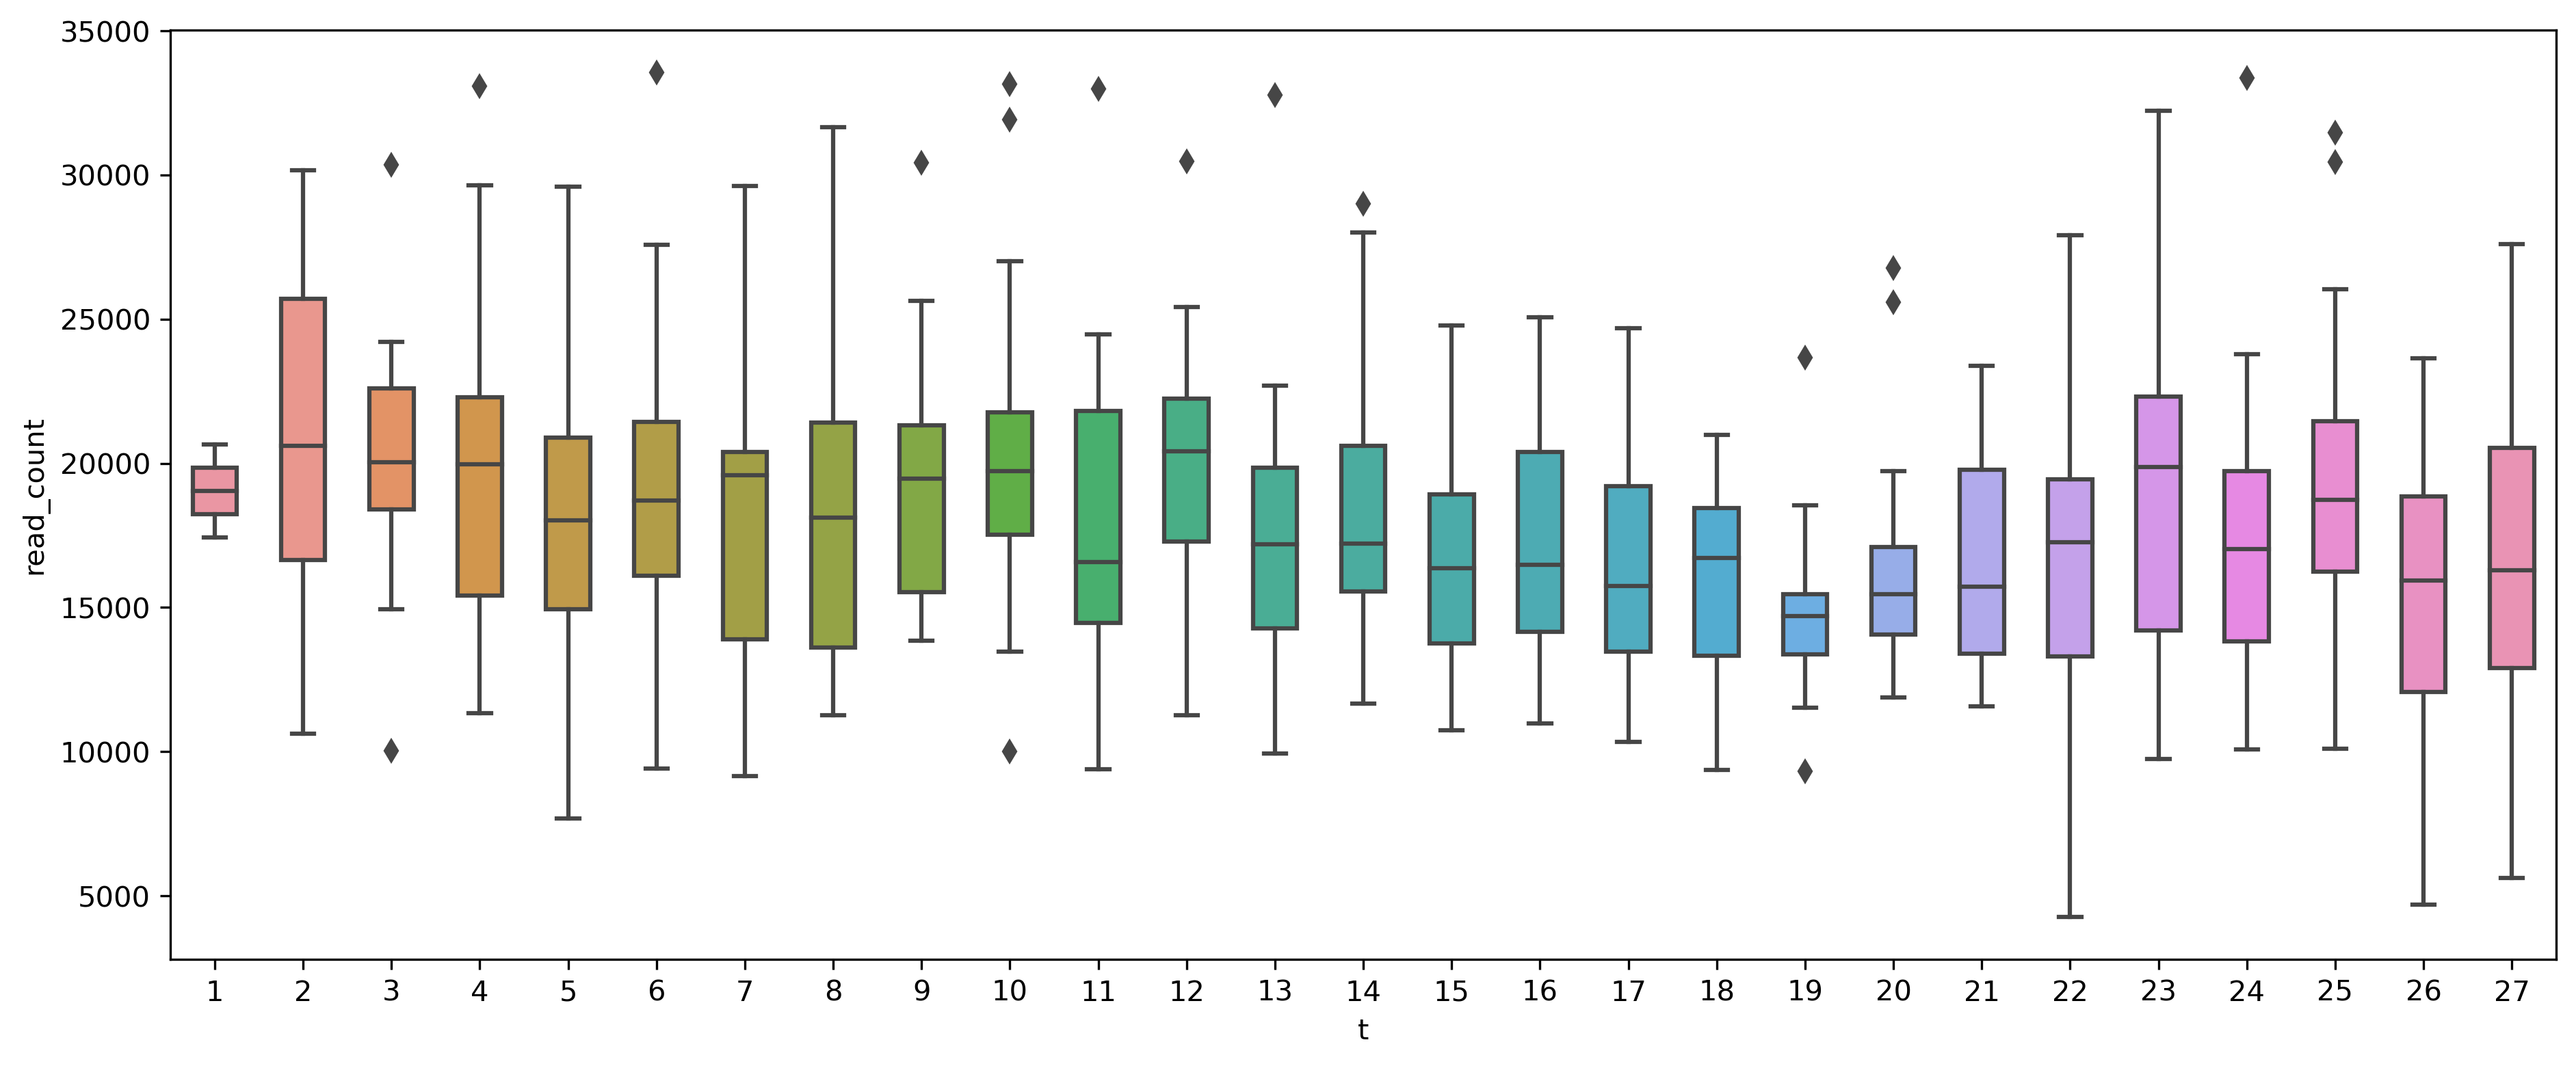

In [14]:
fig = plt.figure(figsize=(15, 6), dpi=300)
#ax = plt.subplot(1,1,1)
_ = sns.boxplot(x='t', y='read_count', data=read_stats, order=sorted(set(read_stats['t'])), width=0.5, )